In [11]:
%%time
import json
import getpass
import requests
import pandas as pd
from time import sleep

url = f'http://www.bursamarketplace.com/index.php?screentype=stocks&board=all&tpl=screener_ajax&type=getResult&action=listing&pagenum=1&sfield=name&stype=desc'
response = requests.get(url)
text = json.loads(response.text)
total_page = int(text['totalpage'])
stock_infos = []
path = f'C:/Users/{getpass.getuser()}/Desktop/Data Science/Data/Bursa/'    

for i in range(1, total_page+1):    
    url = f'http://www.bursamarketplace.com/index.php?screentype=stocks&board=all&tpl=screener_ajax&type=getResult&action=listing&pagenum={i}&sfield=name&stype=desc'
    for attempt in range(3):
        try:
            response = requests.get(url)
        except:
            print(f'\nFail at page {i}, attempt {attempt}')
            sleep(0.5)
        else:
            break
        
    text = json.loads(response.text)
    records = text['records']    
    if isinstance(records, dict): records = list(records.values())
    stock_info = [(t['cashtag'], t['stockcode'], t['name'], t['avgrating']) for t in records]    
    stock_infos.append(stock_info)

info_df = pd.DataFrame(sum(stock_infos, []), columns=['tag', 'code', 'name', 'ratings'])
info_df['ratings'] = info_df['ratings'].astype('int')
info_df.to_excel(path + 'code.xlsx', sheet_name='stock_info', index=False)
print('Done')

Done
Wall time: 21.8 s


In [13]:
%%time
import re
import requests
import getpass
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

def fs_scraper(code=None, frequency=None, path=None):
    fq = {'quarter': 'qr', 'annual': 'yr'}[frequency]
    st_code = {'INC': 'is', 'BAL': 'bs', 'CAS': 'cf'}
    path = path + code.split('.')[0] + '_' + fq + '.xlsx'    
    update = True if os.path.exists(path) else False
    
    with pd.ExcelWriter(path, 'xlsxwriter') as writer:
        
        for statement in ['INC', 'BAL', 'CAS']:
            url = f'http://www.bursamarketplace.com/index.php?tpl=financial_ajax&type=stockfin{st_code[statement]+frequency}&code={code}&fintype={statement}'
            response = requests.get(url)
            soup = BeautifulSoup(response.text)
            if update:
                result = pd.read_excel(path, sheet=statement)
            else:
                result = pd.DataFrame()

            get_index = soup.find_all('div', attrs={'class': 'tb_cell tb_metr'})
            index = pd.Series([cell.text for cell in get_index if cell.text not in ['', '\xa0', 'MYR (MILLION)']])
            if index.shape[0] == 0: continue
            periods = pd.Series(re.findall(f'tb_cell tb_{fq}\d\d', str(soup)))            
            periods = periods.str.replace(f'tb_cell tb_{fq}', '').astype('str').unique()
            year = ''
            headers = []

            for idx, i in enumerate(periods):            
                div = f'tb_cell tb_{fq}{i}'

                if fq == 'qr':                                                                     
                    get_column = soup.find_all('div', attrs={'class': div})      
                    if len(get_column) == 0:                
                        div = div + " tb_div"                                
                        get_column = soup.find_all('div', attrs={'class': div})      

                    col_value = pd.Series([cell.text for cell in get_column])                    
                    if col_value[0] != '\xa0': year = col_value[0]                
                    header, col_value = col_value[1] + ' ' + year, col_value[2:]                                        
                    headers.append(header)
                
                elif fq == 'yr':
                    get_column = soup.find_all('div', attrs={'class': div})                    
                    col_value = pd.Series([cell.text for cell in get_column])
                    if i == '01':
                        headers, col_value = col_value.iloc[:len(periods)], col_value.iloc[len(periods):]
                                            
                try:
                    col_value = col_value.str.replace(',', '') # remove ',' from thousand separator
                except: 
                    pass
                
                col_value.reset_index(drop=True, inplace=True) # reset index start from 0                
                result[headers[idx]] = col_value
                #result = pd.concat([result, col_value], axis=1)                
                
            result = result.applymap(lambda x: re.sub(r'-', str(0), x)).astype(np.float)    
            #result.columns = headers    
            result.index = index            
            result.to_excel(writer, sheet_name=statement)

    print(f'Done crawling {code} for frequency: {frequency.capitalize()}')
    
# def main(codes, frequency, path):
#     from concurrent.futures import ThreadPoolExecutor, as_completed    
#     kwargs = [{'code':code, 'frequency':frequency, 'path':path+code+frequency+'.xlsx'} for code in codes]
#     with ThreadPoolExecutor(max_workers=10) as executor:
#         futures = [executor.submit(fs_scraper, **kwarg) for kwarg in kwargs]
#         for future in as_completed(futures):        
#             future.result()       

if __name__ == '__main__':        
    frequency = 'annual'  
    path = f'C:/Users/{getpass.getuser()}/Desktop/Data Science/Data/Bursa/{frequency}/'    
    code_df = pd.read_excel(path + 'code.xlsx')
    codes = code_df.code.tolist()    
    for code in codes:
        fs_scraper(code, frequency, path)
    #main(codes, frequency, path)

Done crawling SEVE.KL for frequency: Annual
Done crawling ARNK.KL for frequency: Annual
Done crawling ABFM.KL for frequency: Annual
Done crawling ABEL.KL for frequency: Annual
Done crawling ABMF.KL for frequency: Annual
Done crawling ACME.KL for frequency: Annual
Done crawling ACOU.KL for frequency: Annual
Done crawling APTB.KL for frequency: Annual
Done crawling AIMD.KL for frequency: Annual
Done crawling ADVA.KL for frequency: Annual
Done crawling ADVN.KL for frequency: Annual
Done crawling ADVE.KL for frequency: Annual
Done crawling AEMU.KL for frequency: Annual
Done crawling AEML.KL for frequency: Annual
Done crawling AEOM.KL for frequency: Annual
Done crawling ANCR.KL for frequency: Annual
Done crawling AFIN.KL for frequency: Annual
Done crawling ARTW.KL for frequency: Annual
Done crawling AZRB.KL for frequency: Annual
Done crawling AIRA.KL for frequency: Annual
Done crawling AIRX.KL for frequency: Annual
Done crawling AJIN.KL for frequency: Annual
Done crawling AJIY.KL for freque

Done crawling DEST.KL for frequency: Annual
Done crawling DGBA.KL for frequency: Annual
Done crawling DIAL.KL for frequency: Annual
Done crawling DSOM.KL for frequency: Annual
Done crawling DIGS.KL for frequency: Annual
Done crawling DGSB.KL for frequency: Annual
Done crawling DKLS.KL for frequency: Annual
Done crawling DELM.KL for frequency: Annual
Done crawling DOLC.KL for frequency: Annual
Done crawling DOLP.KL for frequency: Annual
Done crawling DOMN.KL for frequency: Annual
Done crawling DPIH.KL for frequency: Annual
Done crawling DPSS.KL for frequency: Annual
Done crawling DRBM.KL for frequency: Annual
Done crawling DUFU.KL for frequency: Annual
Done crawling DUOP.KL for frequency: Annual
Done crawling DUTA.KL for frequency: Annual
Done crawling DBMS.KL for frequency: Annual
Done crawling DWLR.KL for frequency: Annual
Done crawling DYNA.KL for frequency: Annual
Done crawling EATE.KL for frequency: Annual
Done crawling EAHL.KL for frequency: Annual
Done crawling ENOB.KL for freque

Done crawling INNO.KL for frequency: Annual
Done crawling INSS.KL for frequency: Annual
Done crawling ILBM.KL for frequency: Annual
Done crawling INTA.KL for frequency: Annual
Done crawling IOIB.KL for frequency: Annual
Done crawling IOIP.KL for frequency: Annual
Done crawling IPMU.KL for frequency: Annual
Done crawling IQGH.KL for frequency: Annual
Done crawling IREE.KL for frequency: Annual
Done crawling IRKA.KL for frequency: Annual
Done crawling IRIB.KL for frequency: Annual
Done crawling IWCI.KL for frequency: Annual
Done crawling IVRY.KL for frequency: Annual
Done crawling JADE.KL for frequency: Annual
Done crawling JADI.KL for frequency: Annual
Done crawling JAGB.KL for frequency: Annual
Done crawling JAKS.KL for frequency: Annual
Done crawling JKBM.KL for frequency: Annual
Done crawling JTIA.KL for frequency: Annual
Done crawling JAYC.KL for frequency: Annual
Done crawling JCBN.KL for frequency: Annual
Done crawling JCYI.KL for frequency: Annual
Done crawling JERA.KL for freque

Done crawling MPHB.KL for frequency: Annual
Done crawling MQTE.KL for frequency: Annual
Done crawling MQRE.KL for frequency: Annual
Done crawling MSCM.KL for frequency: Annual
Done crawling MBSS.KL for frequency: Annual
Done crawling MBCB.KL for frequency: Annual
Done crawling MPLB.KL for frequency: Annual
Done crawling MSCB.KL for frequency: Annual
Done crawling MSWK.KL for frequency: Annual
Done crawling MYRS.KL for frequency: Annual
Done crawling MSMH.KL for frequency: Annual
Done crawling MTAG.KL for frequency: Annual
Done crawling MTDA.KL for frequency: Annual
Done crawling MTOU.KL for frequency: Annual
Done crawling MUBL.KL for frequency: Annual
Done crawling MUDA.KL for frequency: Annual
Done crawling MJYA.KL for frequency: Annual
Done crawling MUHI.KL for frequency: Annual
Done crawling MUIB.KL for frequency: Annual
Done crawling MUIP.KL for frequency: Annual
Done crawling MITC.KL for frequency: Annual
Done crawling MSPT.KL for frequency: Annual
Done crawling MUHB.KL for freque

Done crawling SAUD.KL for frequency: Annual
Done crawling SIAH.KL for frequency: Annual
Done crawling SCST.KL for frequency: Annual
Done crawling SCWF.KL for frequency: Annual
Done crawling SCCH.KL for frequency: Annual
Done crawling SCGB.KL for frequency: Annual
Done crawling SCHG.KL for frequency: Annual
Done crawling SCCM.KL for frequency: Annual
Done crawling STIK.KL for frequency: Annual
Done crawling SCES.KL for frequency: Annual
Done crawling SCOI.KL for frequency: Annual
Done crawling SCPE.KL for frequency: Annual
Done crawling SDSG.KL for frequency: Annual
Done crawling SCER.KL for frequency: Annual
Done crawling SEAL.KL for frequency: Annual
Done crawling SLKI.KL for frequency: Annual
Done crawling SECU.KL for frequency: Annual
Done crawling SEDA.KL for frequency: Annual
Done crawling SCHB.KL for frequency: Annual
Done crawling SEER.KL for frequency: Annual
Done crawling SEDU.KL for frequency: Annual
Done crawling SENI.KL for frequency: Annual
Done crawling SNTO.KL for freque

Done crawling WLAN.KL for frequency: Annual
Done crawling WTKH.KL for frequency: Annual
Done crawling WZRB.KL for frequency: Annual
Done crawling XIAN.KL for frequency: Annual
Done crawling XIDE.KL for frequency: Annual
Done crawling XINW.KL for frequency: Annual
Done crawling XINH.KL for frequency: Annual
Done crawling XOXB.KL for frequency: Annual
Done crawling YGCB.KL for frequency: Annual
Done crawling YSPS.KL for frequency: Annual
Done crawling YBSI.KL for frequency: Annual
Done crawling YLEE.KL for frequency: Annual
Done crawling YGLC.KL for frequency: Annual
Done crawling YLAI.KL for frequency: Annual
Done crawling YINS.KL for frequency: Annual
Done crawling YLIH.KL for frequency: Annual
Done crawling YNHB.KL for frequency: Annual
Done crawling YONG.KL for frequency: Annual
Done crawling YGON.KL for frequency: Annual
Done crawling YTLS.KL for frequency: Annual
Done crawling YTLL.KL for frequency: Annual
Done crawling YTLP.KL for frequency: Annual
Done crawling YTLR.KL for freque

### Profitability Criteria:

- Positive Net Income (1 point)
- Positive return on assets in the current year (1 point)
- Positive operating cash flow in the current year (1 point)
- Cash flow from operations being greater than net Income (quality of earnings) (1 point)

### Leverage, Liquidity and Source of Funds Criteria:

- Lower ratio of long term debt in the current period, compared to the previous year (decreased leverage) (1 point)
- Higher current ratio this year compared to the previous year (more liquidity) (1 point)
- No new shares were issued in the last year (lack of dilution) (1 point).

### Operating Efficiency Criteria:

- A higher gross margin compared to the previous year (1 point)
- A higher asset turnover ratio compared to the previous year (1 point)

In [11]:
import pandas as pd
import numpy as np
from scipy.special import expit

def get_gnp():        
    print('Run some shit')
    import requests
    from bs4 import BeautifulSoup    
    url = 'https://www.macrotrends.net/countries/MYS/malaysia/gnp-gross-national-product'
    response = requests.get(url)
    soup = BeautifulSoup(response.text)
    table = soup.find_all('table', attrs={'class': 'historical_data_table table table-striped table-bordered'})
    table = table[1].find_all('tr')
    gnp = pd.DataFrame([row.text.split('\n') for row in table[3:]])
    gnp.columns = table[1].text.split('\n')
    gnp.drop('', axis=1, inplace=True)
    gnp.GNP = gnp.GNP.str.replace('\$|B', '').astype(float)
    gnp['Per Capita'] = gnp['Per Capita'].str.replace('\$|,', '').astype(float)
    gnp['Growth Rate'] = gnp['Growth Rate'].str.replace('\%', '').astype(float)
    gnp.set_index('Year', drop=True, inplace=True)
    gnp.index = gnp.index.astype('int')    
    return gnp

class Score:
    """
    Input: df, concatenated df by rows - Income Statement, Balance Sheet and Cash Flow statement
    """                
    gnp = get_gnp()
    def __init__(self, df):
        self.revenue = df.loc['Revenue', :]
        self.net_sales = df.loc['Net Sales', :]
        self.cogs = df.loc['Cost of Revenue, Total', :]
        self.sga = df.loc['Selling/General/Admin. Expenses, Total', :]
        self.gross_profit = df.loc['Gross Profit', :]               
        self.ebit = df.loc['Net Income Before Taxes', :]
        self.net_profit = df.loc['Net Income', :]

        self.total_asset = df.loc['Total Assets', :]            
        self.current_asset = df.loc['Total Current Assets', :]
        self.ppe = df.loc['Property/Plant/Equipment, Total - Net', :]
        self.retain_earning = df.loc['Retained Earnings (Accumulated Deficit)', :]        
        self.total_liability = df.loc['Total Liabilities', :]
        self.current_liability = df.loc['Total Current Liabilities', :]
        self.long_debt = df.loc['Total Long Term Debt', :]
        self.total_equity = df.loc['Total Equity', :]
        
        self.cash = df.loc['Cash and Short Term Investments', :]
        self.operating_cf = df.loc['Cash from Operating Activities', :]
        self.net_receivable = df.loc['Total Receivables, Net', :]
        self.security = df.loc['Security Deposits', :]
        self.depreciation = df.loc['Depreciation/Depletion', :]
        self.share = df.loc['Total Common Shares Outstanding', :]           
                        
        self.working_capital = self.current_asset - self.current_liability        
        self.f = None
        self.m = None
        self.z = None
        self.o = None    
        
    def f_score(self):
        revenue = self.revenue
        net_sales = self.net_sales
        gross_profit = self.gross_profit
        net_profit = self.net_profit
        total_asset = self.total_asset
        current_asset = self.current_asset
        long_debt = self.long_debt
        current_liability = self.current_liability
        operating_cf = self.operating_cf
        share = self.share
        
        average_asset = total_asset.rolling(window=2).mean().shift(-1).ffill()
        roa = net_profit / total_asset
        current_ratio = current_asset / current_liability
        gross_margin = gross_profit / net_sales
        asset_turnover = revenue / average_asset

        headers = ['Positive Income', 'Positive ROA', 'Positive OCF', 'OCF > Income', 
                   'Lower Long term debt ratio', 'Higher current ratio', 'No New Share',
                   'Higher Gross Margin', 'Higher asset turnover']

        f_score = pd.concat([net_profit > 0,
                            (roa > 0),
                            (operating_cf > 0),
                            (operating_cf > net_profit),
                            ((long_debt / total_asset).diff(-1).fillna(0) <= 0),
                            (current_ratio.diff(-1).fillna(0) > 0),
                            (share.diff(-1).fillna(0) >= 0),
                            (gross_margin.diff(-1).fillna(0) > 0),
                            (asset_turnover.diff(-1).fillna(0) > 0)], axis=1)
        f_score.columns = headers
        f_score = f_score.applymap(int)    
        f_score.index = f_score.index.year
        f_score = f_score.sum(axis=1)
        f_score = pd.DataFrame(f_score.values, index=f_score.index, columns=['f_score'])    
        self.f = f_score 
        return f_score

    def m_score(self):       
        net_sales = self.net_sales
        cogs = self.cogs        
        sga = self.sga
        ppe = self.ppe        
        total_asset = self.total_asset
        current_asset = self.current_asset        
        long_debt = self.long_debt
        current_liability = self.current_liability        
        cash = self.cash
        net_receivable = self.net_receivable                
        depreciation = self.depreciation
        security = self.security
        working_capital = self.working_capital
        
        DSR = net_receivable / net_sales
        DSRI = (DSR / DSR.shift(-1)).fillna(0)

        GM = (net_sales - cogs) / net_sales
        GMI = (GM.shift(-1) / GM).fillna(0)

        AQ = 1 - (current_asset + ppe + security) / total_asset
        AQI = (AQ / AQ.shift(-1)).fillna(0)

        SGI = (net_sales / net_sales.shift(-1)).fillna(0)

        DEP = depreciation / (depreciation + ppe)
        DEPI = (DEP / DEP.shift(-1)).fillna(0)

        SGA = sga / net_sales
        SGAI = (SGA / SGA.shift(-1)).fillna(0)

        LVG = (current_liability + long_debt) / total_asset
        LVGI = (LVG / LVG.shift(-1)).fillna(0)

        TATA = (working_capital - cash - depreciation).diff(-1).fillna(0)

        m = -4.84 + 0.92 * DSRI + 0.528 * GMI + 0.404 * AQI + 0.892 * SGI + 0.115 * DEPI - 0.172 * SGAI + 4.679 * TATA - 0.327 * LVGI
        m = pd.DataFrame(m.values, index=m.index.year, columns=['m_score'])
        self.m = m
        return m

    def z_score(self):
        """
            A = working capital / total assets
            B = retained earnings / total assets
            C = earnings before interest and tax / total assets
            D = market value of equity / total liabilities
            E = sales / total assets
            Z-Score = 1.2A + 1.4B + 3.3C + 0.6D + 1.0E
            A score below 1.8 means it's likely the company is headed for bankruptcy, 
            while companies with scores above 3 are not likely to go bankrupt
        """
        working_capital = self.working_capital
        total_asset = self.total_asset
        retain_earning = self.retain_earning
        ebit = self.ebit
        total_equity = self.total_equity
        total_liability = self.total_liability
        net_sales = self.net_sales        
        A = working_capital / total_asset
        B = retain_earning / total_asset
        C = ebit / total_asset
        D = total_equity / (total_liability + total_equity)
        E = net_sales / total_asset
        Z = 1.2 * A + 1.4 * B + 3.3 * C + 0.6 * D + 1.0 * E        
        Z = pd.DataFrame(Z.values, index=Z.index.year, columns=['z_score'])
        self.z = Z
        return Z
    
    def o_score(self):
        """
        GNP (float): Gross National Product Index (Growth Rate, %)
        Ohlson O-Score is the result of a 9-factor linear combination of coefficient-weighted business ratios         
        """        
        total_asset = self.total_asset
        total_liability = self.total_liability
        current_asset = self.current_asset
        current_liability = self.current_liability
        net_profit = self.net_profit
        operating_cf = self.operating_cf
        working_capital = self.working_capital
        #if gnp is None: gnp = get_gnp()        
        GNP = self.gnp.loc[list(total_asset.index.year - 1), 'Growth Rate']
        GNP.index = total_asset.index
        X = (total_liability > total_asset).astype('int')
        Y = ((score.net_profit.shift(1) < 0) | (score.net_profit < 0)).astype('int')
        Z = (net_profit.diff(-1) / (net_profit.abs() + net_profit.shift(-1).abs())).fillna(0)        
        T = -1.32 - 0.407 * np.log(total_asset/GNP) + 6.03 * total_liability / total_asset - 1.43 * working_capital / total_asset + 0.0757 * current_liability / current_asset - 1.72 *  X - 2.37 * net_profit / total_asset - 1.83 * operating_cf  / total_liability + 0.285 * Y - 0.521 * Z        
        T = T.apply(expit)        
        O = pd.DataFrame(T.values, index= T.index.year, columns=['o_score'])
        self.o = O
        return O

NameError: name 'gnp' is not defined

['O Score Formula'] (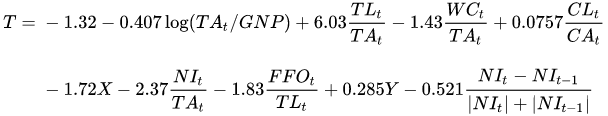)

In [12]:
import pandas as pd
path = 'C:/Users/WONG YC/Desktop/Data Science/data/Bursa/annual/'
xlsx = pd.ExcelFile(path + 'ACME_yr.xlsx')
df = pd.concat((pd.read_excel(xlsx, sheet_name=sheet, index_col=0) for sheet in xlsx.sheet_names), axis=0)
df.columns = pd.DatetimeIndex(df.columns)
df = df[df.columns.sort_values(ascending=False)]

score = Score(df)

In [22]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
data = np.random.random((1000,100))
labels = np.random.randint(2,size=(1000,1))
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(data,labels,epochs=10,batch_size=32)
predictions = model.predict(data)

Epoch 1/10
1000/1000 [==============================] - 0s 418us/step - loss: 0.7175 - acc: 0.4780
Epoch 2/10
1000/1000 [==============================] - 0s 47us/step - loss: 0.7028 - acc: 0.4930
Epoch 3/10
1000/1000 [==============================] - 0s 44us/step - loss: 0.6969 - acc: 0.5130
Epoch 4/10
1000/1000 [==============================] - 0s 58us/step - loss: 0.6916 - acc: 0.5290
Epoch 5/10
1000/1000 [==============================] - 0s 57us/step - loss: 0.6899 - acc: 0.5400
Epoch 6/10
1000/1000 [==============================] - 0s 48us/step - loss: 0.6850 - acc: 0.5510
Epoch 7/10
1000/1000 [==============================] - 0s 47us/step - loss: 0.6784 - acc: 0.5740
Epoch 8/10
1000/1000 [==============================] - 0s 55us/step - loss: 0.6766 - acc: 0.5780
Epoch 9/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.6726 - acc: 0.5940
Epoch 10/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.6678 - acc: 0.6210
